In [1]:
import os
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import pyvips
import glob

# Params
sample_n = 8
min_sample_n = 0

# Paths
root = '/media/latlab/MR/projects/kaggle-ubc-ocean'
data_dir = os.path.join(root, 'data')
results_dir = os.path.join(root, 'results')
train_csv = 'train.csv'
train_image_dir = os.path.join(data_dir, 'train_images')
train_thumbnail_dir = os.path.join(data_dir, 'train_thumbnails')
train_mask_dir = os.path.join(data_dir, 'train_masks')
tile_set_name = 'tumor_detection_tiles_1024_p50_drop60'
tiles_dir = os.path.join(results_dir, tile_set_name)

if min_sample_n > 0:
    out_name = f'{tile_set_name}_minsample{min_sample_n}'
else:
    out_name = tile_set_name

# Load data
df = pd.read_csv(os.path.join(data_dir, train_csv))

# Get only images with masks
mask_id_list = [int(os.path.splitext(os.path.basename(mask_path))[0]) for mask_path in glob.glob(os.path.join(train_mask_dir, '*.png'))]
df = df[df['image_id'].isin(mask_id_list)].reset_index(drop=True)
df

image_id label  image_width  image_height  is_tma
0          66  LGSC        48871         48195   False
1        1020  HGSC        36585         33751   False
2        1101  HGSC        26306         18403   False
3        1252  HGSC        60420         27480   False
4        1925  HGSC        44847         32951   False
..        ...   ...          ...           ...     ...
147     63165    CC        30342         12783   False
148     63941  HGSC        47123         36600   False
149     65022  LGSC        53355         46675   False
150     65094    MC        55042         45080   False
151     65533  HGSC        45190         33980   False

[152 rows x 5 columns]

In [2]:
tiles_df = pd.DataFrame(columns=['image_id', 'orig_image_id', 'label', 'is_tma'])
for i, row in df.iterrows():
    orig_image_id = row['image_id']
    try:
        image_id_list = [os.path.splitext(x)[0] for x in os.listdir(os.path.join(tiles_dir, str(orig_image_id))) if x.endswith('.png')]

        # Load labels
        labels_path = os.path.join(tiles_dir, str(orig_image_id), 'labels.csv')
        labels_df = pd.read_csv(labels_path).set_index('image_id')
        labels_df = labels_df.loc[image_id_list,:]
        
        curr_df = pd.DataFrame({'image_id': image_id_list, 
                                'orig_image_id': orig_image_id, 
                                'label': row['label'], 
                                'orig_image_width': row['image_width'], 
                                'orig_image_height': row['image_height'], 
                                'is_tma': row['is_tma'],
                                'tumor': labels_df['tumor'],
                                'stroma': labels_df['stroma'],
                                'necrosis': labels_df['necrosis'],
                                'background': labels_df['background']})
        tiles_df = pd.concat((tiles_df, curr_df))
    except:
        print(f'No tiles for {orig_image_id}')
tiles_df = tiles_df.reset_index(drop=True).astype({'orig_image_width': 'int32', 'orig_image_height': 'int32'})
tiles_df['is_tumor'] = tiles_df['tumor'] > 0.95
tiles_df['not_tumor'] = ((tiles_df['stroma'] + tiles_df['necrosis']) > 0.5) & (tiles_df['tumor'] < 0.05)
tiles_df = tiles_df[tiles_df['is_tumor'] | tiles_df['not_tumor']]
tiles_df

image_id orig_image_id label is_tma  orig_image_width  \
10      000519_40-11            66  LGSC  False             48871   
13      000934_23-20            66  LGSC  False             48871   
15       000323_36-7            66  LGSC  False             48871   
20      001605_22-34            66  LGSC  False             48871   
24      001611_28-34            66  LGSC  False             48871   
...              ...           ...   ...    ...               ...   
158636   000165_31-4         65533  HGSC  False             45190   
158643   000196_17-5         65533  HGSC  False             45190   
158646   001040_6-24         65533  HGSC  False             45190   
158649  000961_17-22         65533  HGSC  False             45190   
158652  000924_25-21         65533  HGSC  False             45190   

        orig_image_height     tumor    stroma  necrosis  background  is_tumor  \
10                  48195  1.000000  0.000000       0.0    0.000000      True   
13                  48195  1.000000  0.000000       0.0    0.000000      True   
15                  48195  1.000000  0.000000       0.0    0.000000      True   
20                  48195  1.000000  0.000000       0.0    0.000000      True   
24                  48195  1.000000  0.000000       0.0    0.000000      True   
...                   ...       ...       ...       ...         ...       ...   
158636              33980  0.000000  0.982633       0.0    0.017367     False   
158643              33980  1.000000  0.000000       0.0    0.000000      True   
158646              33980  0.996569  0.000000       0.0    0.003431      True   
158649              33980  0.994704  0.000000       0.0    0.005296      True   
158652              33980  0.000000  0.780580       0.0    0.219420     False   

        not_tumor  
10          False  
13          False  
15          False  
20          False  
24          False  
...           ...  
158636       True  
158643      False  
158646      False  
158649      False  
158652       True  

[27495 rows x 12 columns]

In [3]:
# Undersample to N tile/image
def sampler(x, n):
    if len(x) < n:
        return x
    else:
        return x.sample(n)
tiles_df_sample_tumor = tiles_df[tiles_df.is_tumor].groupby('orig_image_id').apply(lambda x: sampler(x, sample_n//2)).reset_index(drop=True)
tiles_df_sample_ntumor = tiles_df[~tiles_df.is_tumor].groupby('orig_image_id').apply(lambda x: sampler(x, sample_n//2)).reset_index(drop=True)
tiles_df_sample = pd.concat((tiles_df_sample_tumor, tiles_df_sample_ntumor)).reset_index(drop=True)
tiles_df_sample.to_csv(os.path.join(results_dir, f'{out_name}_sample{sample_n}.csv'), index=False)
display(tiles_df_sample_tumor)
display(tiles_df_sample_ntumor)
print('tumor tiles ratio:', len(tiles_df_sample_tumor)/len(tiles_df_sample))

image_id orig_image_id label is_tma  orig_image_width  \
0    000741_22-16            66  LGSC  False             48871   
1    000511_32-11            66  LGSC  False             48871   
2    000844_29-18            66  LGSC  False             48871   
3    000708_37-15            66  LGSC  False             48871   
4    000814_23-23          1020  HGSC  False             36585   
..            ...           ...   ...    ...               ...   
603  001811_30-34         65094    MC  False             55042   
604  000783_19-18         65533  HGSC  False             45190   
605   000251_27-6         65533  HGSC  False             45190   
606  001187_18-27         65533  HGSC  False             45190   
607  000595_11-14         65533  HGSC  False             45190   

     orig_image_height     tumor  stroma  necrosis  background  is_tumor  \
0                48195  0.953053     0.0       0.0    0.046947      True   
1                48195  0.992668     0.0       0.0    0.007332      True   
2                48195  1.000000     0.0       0.0    0.000000      True   
3                48195  1.000000     0.0       0.0    0.000000      True   
4                33751  1.000000     0.0       0.0    0.000000      True   
..                 ...       ...     ...       ...         ...       ...   
603              45080  0.976859     0.0       0.0    0.023141      True   
604              33980  1.000000     0.0       0.0    0.000000      True   
605              33980  1.000000     0.0       0.0    0.000000      True   
606              33980  0.965444     0.0       0.0    0.034556      True   
607              33980  1.000000     0.0       0.0    0.000000      True   

     not_tumor  
0        False  
1        False  
2        False  
3        False  
4        False  
..         ...  
603      False  
604      False  
605      False  
606      False  
607      False  

[608 rows x 12 columns]

image_id orig_image_id label is_tma  orig_image_width  \
0    000902_39-19            66  LGSC  False             48871   
1    000853_38-18            66  LGSC  False             48871   
2    000903_40-19            66  LGSC  False             48871   
3    001309_14-28            66  LGSC  False             48871   
4    000855_28-24          1020  HGSC  False             36585   
..            ...           ...   ...    ...               ...   
518  002150_45-40         65094    MC  False             55042   
519  001104_25-25         65533  HGSC  False             45190   
520   000209_30-5         65533  HGSC  False             45190   
521  001110_31-25         65533  HGSC  False             45190   
522   000254_30-6         65533  HGSC  False             45190   

     orig_image_height  tumor    stroma  necrosis  background  is_tumor  \
0                48195    0.0  0.628839       0.0    0.371161     False   
1                48195    0.0  0.983667       0.0    0.016333     False   
2                48195    0.0  0.870150       0.0    0.129850     False   
3                48195    0.0  0.580971       0.0    0.419029     False   
4                33751    0.0  0.708297       0.0    0.291703     False   
..                 ...    ...       ...       ...         ...       ...   
518              45080    0.0  1.000000       0.0    0.000000     False   
519              33980    0.0  1.000000       0.0    0.000000     False   
520              33980    0.0  1.000000       0.0    0.000000     False   
521              33980    0.0  1.000000       0.0    0.000000     False   
522              33980    0.0  0.705390       0.0    0.294610     False   

     not_tumor  
0         True  
1         True  
2         True  
3         True  
4         True  
..         ...  
518       True  
519       True  
520       True  
521       True  
522       True  

[523 rows x 12 columns]

tumor tiles ratio: 0.537577365163572


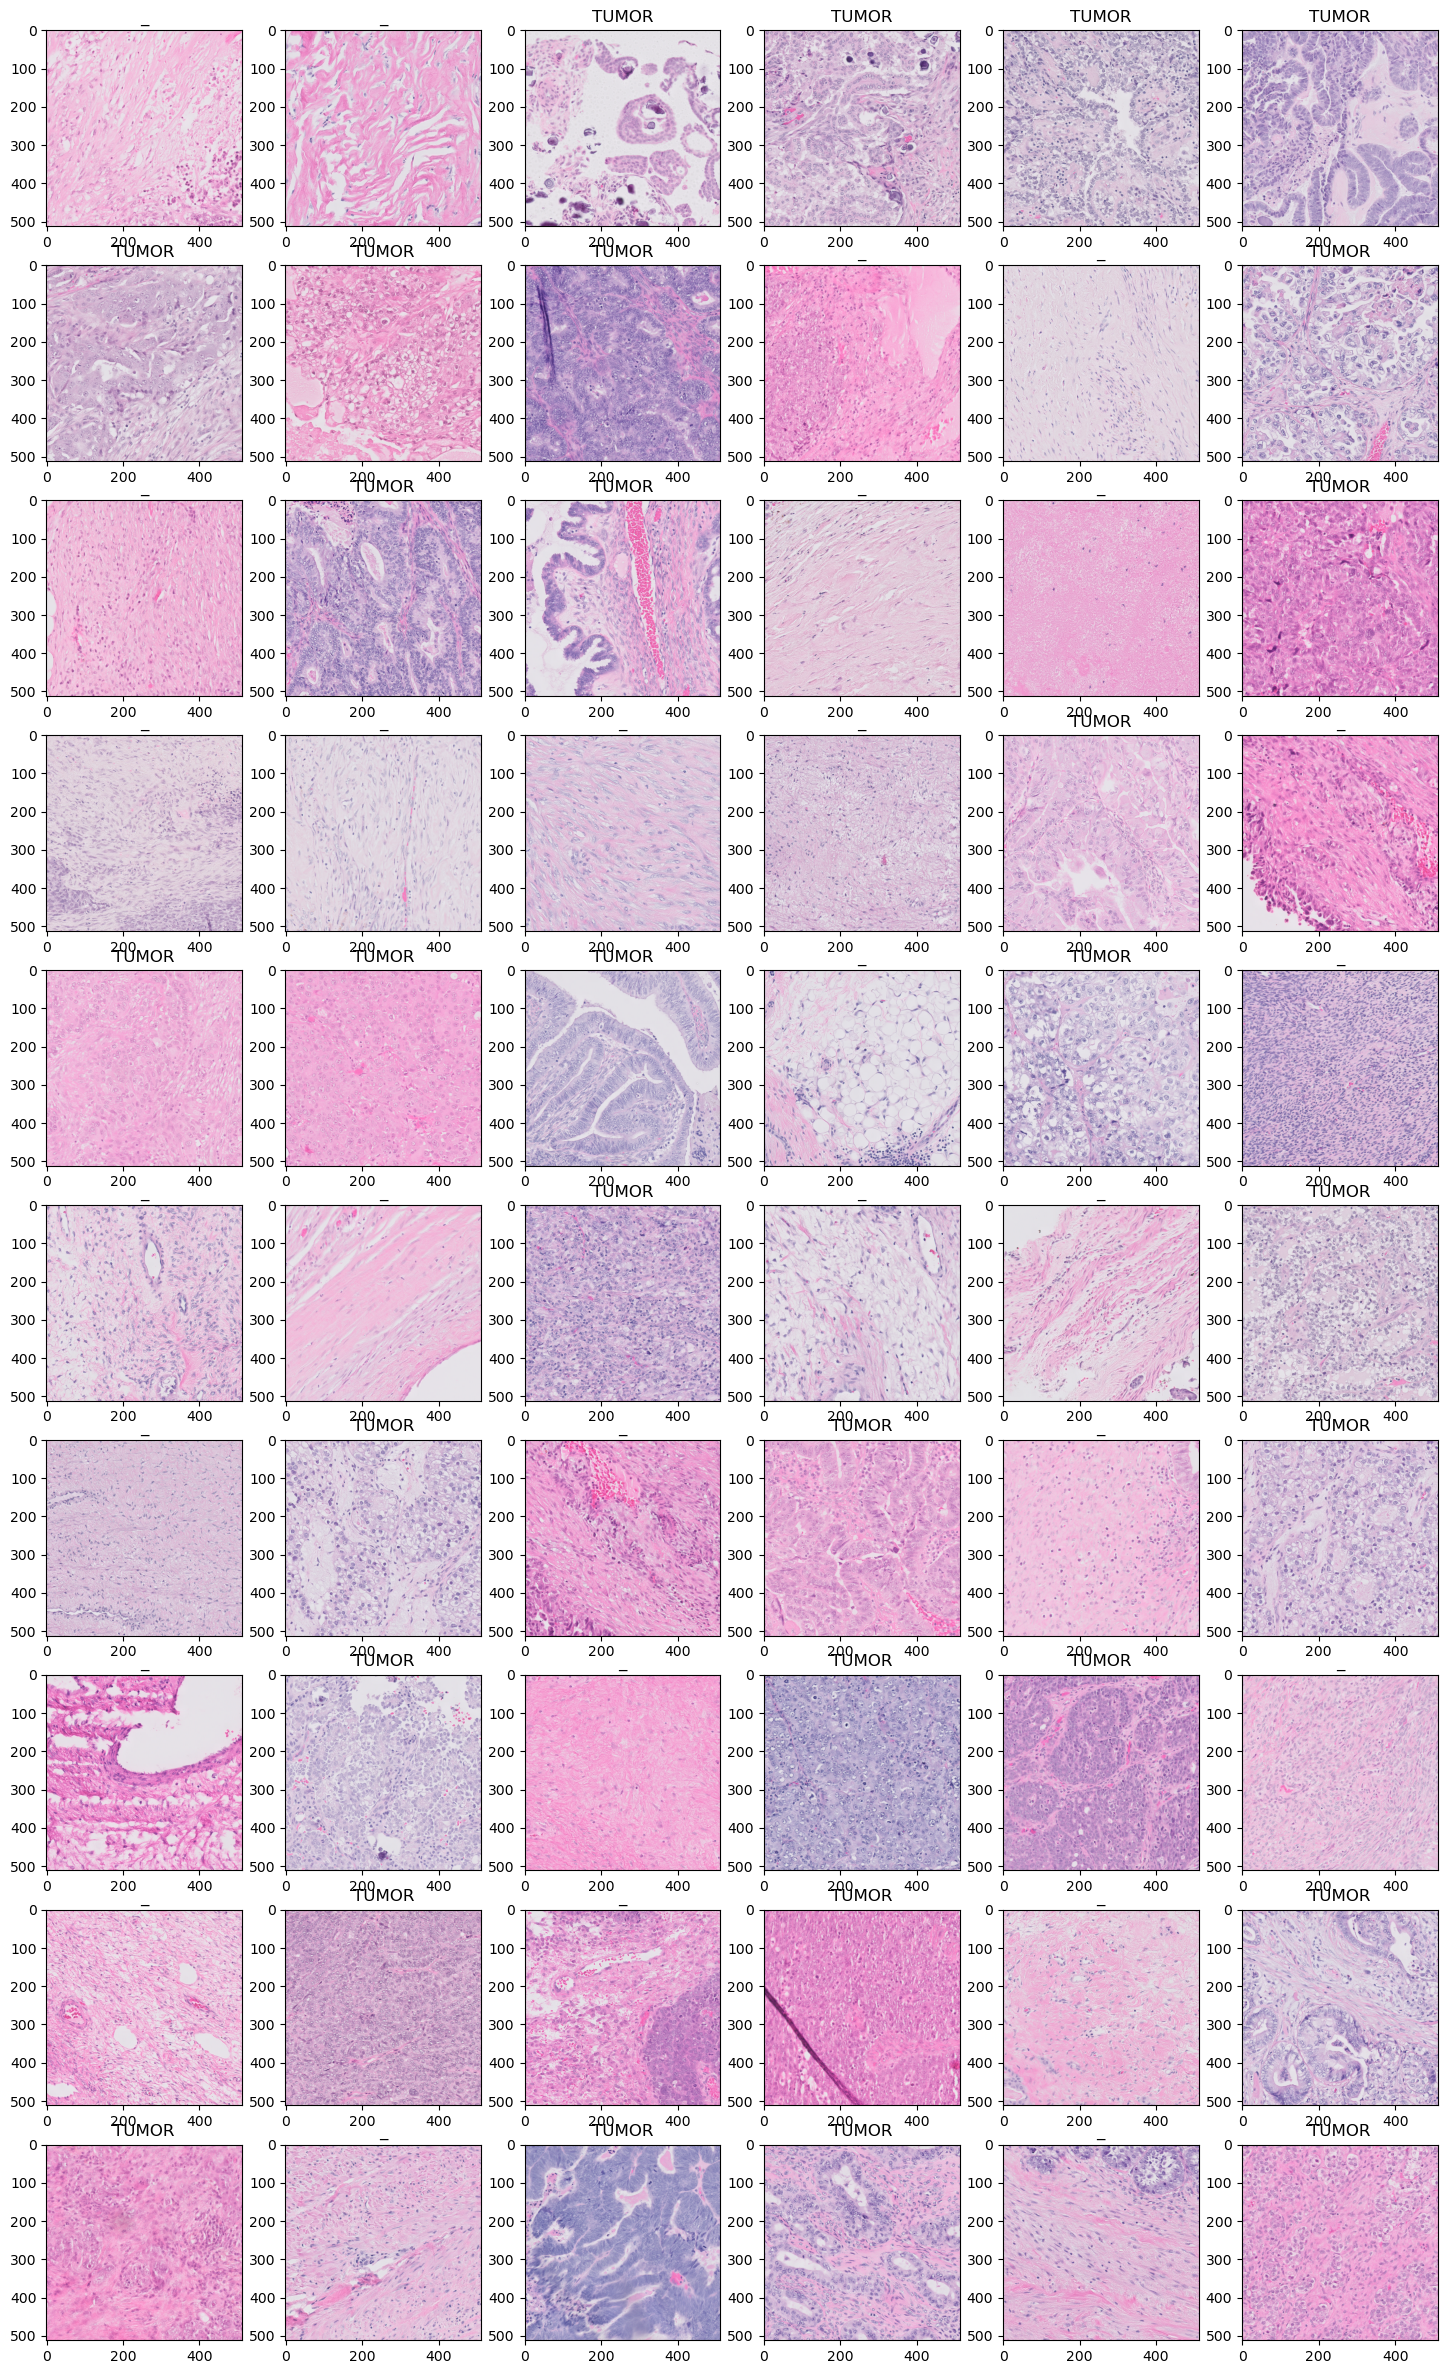

In [4]:
nrows = 10
ncols = 6

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*3, nrows*3))
for i, row in tiles_df_sample.sample(frac=1).reset_index(drop=True).iterrows():
    if i >= (nrows*ncols):
        break
    img_path = os.path.join(tiles_dir, str(row['orig_image_id']), str(row['image_id'] + '.png'))
    # img = plt.imread(img_path)
    img = pyvips.Image.new_from_file(img_path).numpy()
    # if np.max(img) > 1.5:
    #     img = img / 255.0
    ax = axes[i // ncols, i % ncols]
    ax.set_title('TUMOR' if row['is_tumor'] else '_')
    ax.imshow(img)